## Perform Facial Recognition with Deep Learning in Keras Using CNN

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout


from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools

## DATA
ORL face database composed of 400 images of size 92 x 112. There are 40 people, 10 images per person.

In [2]:
location= r'C:\Users\keert\Downloads\ORL_faces.npz'

In [5]:
# load dataset
data = np.load(location)

In [17]:
type(data)

numpy.lib.npyio.NpzFile

In [22]:
list(data.keys())


['testY', 'testX', 'trainX', 'trainY']

In [19]:
data['trainX'].shape, data['trainY'].shape, data['testX'].shape, data['testY'].shape, 

((240, 10304), (240,), (160, 10304), (160,))

In [14]:
data['trainX'][0],data['trainX'].shape

(array([48., 49., 45., ..., 47., 46., 46.]), (240, 10304))

In [32]:
data['trainX'][0],data['testY'][0],

(array([48., 49., 45., ..., 47., 46., 46.]), 0)

In [39]:
#Number of Targets
np.unique(data['testY'])


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8)

In [40]:
# load the "Train Images"
X_train = data['trainX']
X_train[1]

array([60., 60., 62., ..., 32., 34., 34.])

In [41]:
# normalize every image
X_train = np.array(X_train,dtype='float32')/255
X_train[1]

array([0.23529412, 0.23529412, 0.24313726, ..., 0.1254902 , 0.13333334,
       0.13333334], dtype=float32)

In [42]:
X_test = data['testX']
X_test = np.array(X_test,dtype='float32')/255

In [44]:
# load the Label of Images
y_train = data['trainY']
y_test  = data['testY']

# show the train and test Data format
# print('x_train : {}'.format(x_train[:]))
print('X_train shape: {}'.format(X_train.shape))
print('y-train shape: {}'.format(y_train.shape))
print('X_test shape : {}'.format(X_test.shape))
print('y-test shape : {}'.format(y_test.shape))

X_train shape: (240, 10304)
y-train shape: (240,)
X_test shape : (160, 10304)
y-test shape : (160,)


In [45]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=uint8),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12], dtype=int64))

In [49]:
# np.unique(y_train, return_counts=False)

In [48]:
np.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=uint8),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       dtype=int64))

## Split the dataset - Validate and train the data

In [50]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, 
                                                                              y_train, 
                                                                              test_size    = .20, 
                                                                              random_state = 1234,)

### Change the size of the images
For using the CNN, you need to change the size of images.

Transform the images to equal sizes to feed in CNN.

In [64]:
im_rows    = 112
im_cols    =  92
batch_size = 512

im_shape   = (im_rows, im_cols, 1)

In [65]:
im_shape

(112, 92, 1)

In [66]:
# change the size of images
X_train_split = X_train_split.reshape(X_train_split.shape[0], * im_shape)
X_test        = X_test.reshape(        X_test.shape[0],       * im_shape)
X_valid_split = X_valid_split.reshape(X_valid_split.shape[0], * im_shape)

print('X_train_split shape: {}'.format(X_train_split.shape))
print('X_test shape:  {}'.format(X_test.shape))

X_train_split shape: (192, 112, 92, 1)
X_test shape:  (160, 112, 92, 1)


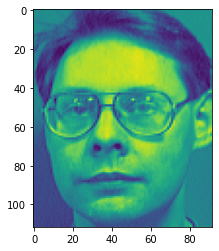

In [72]:
#sample

plt.imshow(X_train_split[1]) 

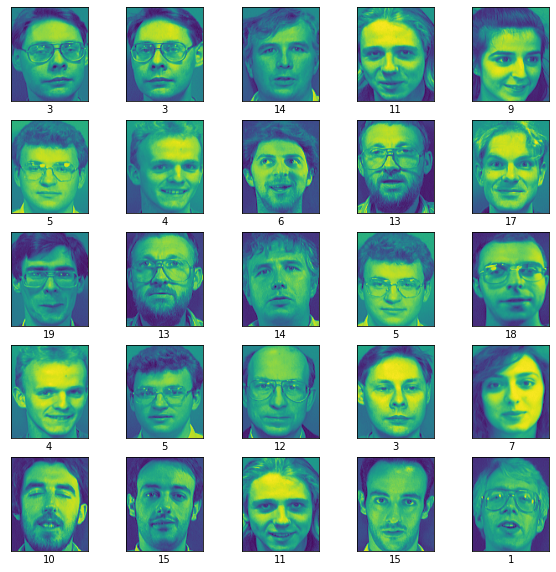

In [82]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    #plt.imshow(X_train_split[i] , cmap=plt.cm.binary)
    plt.imshow(X_train_split[i] )
    plt.xlabel(y_train_split[i])

### Let's build a CNN model that has 3 main layers
Convolotional Layer,
Pooling Layer,
Fully Connected Layer

In [116]:
# Config 1 : 1/.93
cnn_model= Sequential([
                        Conv2D(filters=54,kernel_size=3,  activation='relu', input_shape= im_shape),
                        MaxPooling2D(pool_size=2),
                        Conv2D(filters=36, kernel_size=3, activation='relu', input_shape= im_shape),
                        MaxPooling2D(pool_size=2),
                        Flatten(),
                        # Dense(2024, activation='relu'),
                        # Dropout(0.5),
                        Dense(1024, activation='relu'),
                        Dropout(0.5),
                        Dense(512, activation='relu'),
                        Dropout(0.5),
                        Dense(20, activation='softmax')   #20 is the number of outputs
])

cnn_model.compile(
    loss = 'sparse_categorical_crossentropy',                #'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics   = ['accuracy']
)

In [117]:
cnn_model.summary()  #Model parameters

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 110, 90, 54)       540       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 55, 45, 54)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 53, 43, 36)        17532     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 26, 21, 36)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 19656)             0         
                                                                 
 dense_11 (Dense)            (None, 1024)             

In [118]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [110]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

In [119]:
%%time
history=cnn_model.fit(
                    np.array(X_train_split), 
                    np.array(y_train_split), 
                    batch_size     = 32,
                    epochs         = 500, 
                    verbose        = 0,
                    validation_data= (np.array(X_valid_split), np.array(y_valid_split)),
                    callbacks      = [early_stop, tfdocs.modeling.EpochDots(report_every=10, dot_every=1)]
)


Epoch: 0, accuracy:0.0312,  loss:3.0226,  val_accuracy:0.0208,  val_loss:3.0064,  
..........
Epoch: 10, accuracy:0.1875,  loss:2.7924,  val_accuracy:0.2500,  val_loss:2.8633,  
..........
Epoch: 20, accuracy:0.5938,  loss:1.7358,  val_accuracy:0.6875,  val_loss:1.7536,  
..........
Epoch: 30, accuracy:0.8125,  loss:0.7299,  val_accuracy:0.9375,  val_loss:0.6057,  
..........
Epoch: 40, accuracy:0.8854,  loss:0.3889,  val_accuracy:0.9792,  val_loss:0.2401,  
..........
Epoch: 50, accuracy:0.9844,  loss:0.1524,  val_accuracy:0.9792,  val_loss:0.1259,  
..........
Epoch: 60, accuracy:0.9479,  loss:0.1666,  val_accuracy:0.9792,  val_loss:0.0882,  
..........
Epoch: 70, accuracy:0.9896,  loss:0.0666,  val_accuracy:0.9792,  val_loss:0.0759,  
..........
Epoch: 80, accuracy:0.9948,  loss:0.0529,  val_accuracy:0.9792,  val_loss:0.0470,  
..........CPU times: total: 13min 47s
Wall time: 2min 8s


In [120]:
# %%time
# history=cnn_model.fit(
#                     np.array(X_train_split), 
#                     np.array(y_train_split), 
#                     batch_size     = 32,
#                     epochs         = 300, 
#                     verbose        = 0,
#                     validation_data= (np.array(X_valid_split), np.array(y_valid_split)),
#                     callbacks      = [early_stop, tfdocs.modeling.EpochDots(report_every=5, dot_every=1)]
# )

### Evaluate Test data

In [121]:
from prettytable import PrettyTable
result = PrettyTable()

result.field_names = ["", "Loss", "Accuracy"]

score_train = cnn_model.evaluate(np.array(X_train_split),  np.array(y_train_split), verbose=0)
score_test  = cnn_model.evaluate(np.array(X_test),         np.array(y_test),        verbose=0)

result.add_row(["Training", score_train[0], score_train[1]])
result.add_row(["Testing",  score_test[0],  score_test[1]])

print(result)

+----------+-----------------------+-------------------+
|          |          Loss         |      Accuracy     |
+----------+-----------------------+-------------------+
| Training | 0.0013696829555556178 |        1.0        |
| Testing  |  0.22465547919273376  | 0.949999988079071 |
+----------+-----------------------+-------------------+


In [122]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


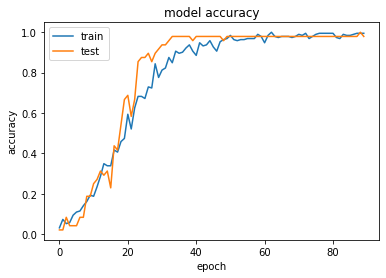

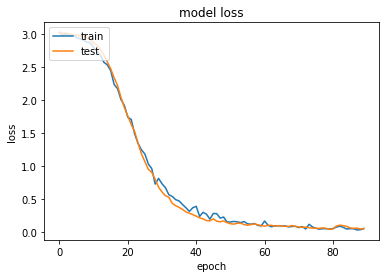

In [123]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## PLotting confusion Matrix

In [135]:
predicted =np.array( cnn_model.predict(X_test))
print(predicted)

5/5 [==============================] - 0s 47ms/step
[[9.8670548e-01 3.1348344e-04 4.9591172e-06 ... 1.5676196e-04
  9.0410877e-03 2.5884974e-06]
 [5.4128963e-01 1.3996202e-03 1.5616034e-04 ... 7.8277121e-04
  1.0428348e-02 7.1794029e-06]
 [9.2000544e-01 1.7645741e-04 8.0728176e-05 ... 2.2862339e-03
  5.9100308e-02 2.7877513e-06]
 ...
 [6.0050382e-09 1.6511220e-06 3.1725632e-04 ... 6.0177290e-06
  2.4144173e-10 9.9714774e-01]
 [1.9848631e-08 4.7072166e-07 5.1054009e-04 ... 3.9557081e-06
  4.8625182e-10 9.9586910e-01]
 [4.4738266e-10 3.2406795e-08 2.4982555e-07 ... 6.9838052e-08
  7.6193921e-12 9.9997914e-01]]


In [136]:
print(y_test)

[ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19]


In [138]:

# ynew =np.argmax(X_test)# cnn_model.predict_classes(X_test)
ynew=np.argmax(predicted,axis=1)
ynew

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4, 17,  4,  4,  4, 17,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  3,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  7,  9,  9,  9,  7, 10, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
       12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15,  0, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 18, 18,  7, 18, 18, 18, 15, 18, 19,
       19, 19, 19, 19, 19, 19, 19], dtype=int64)

accuracy : 
0.95
Confusion matrix, without normalization
[[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 6 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]
Confusion matrix, without normalization


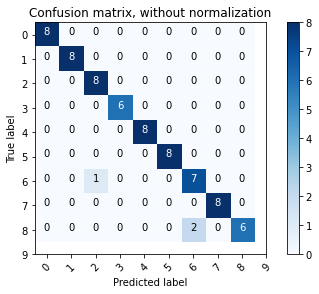

Confusion matrix, without normalization


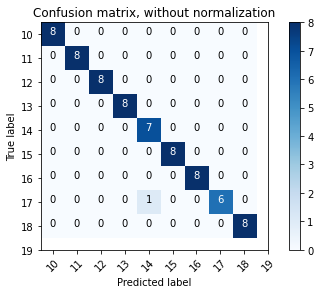

Confusion matrix:
[[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 6 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1

In [139]:


Acc=accuracy_score(y_test, ynew)
print("accuracy : ")
print(Acc)
#/tn, fp, fn, tp = confusion_matrix(np.array(y_test), ynew).ravel()
cnf_matrix=confusion_matrix(np.array(y_test), ynew)

y_test1 = np_utils.to_categorical(y_test, 20)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


print('Confusion matrix, without normalization')
print(cnf_matrix)

plt.figure()
plot_confusion_matrix(cnf_matrix[1:10,1:10], classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix[11:20,11:20], classes=[10,11,12,13,14,15,16,17,18,19],
                      title='Confusion matrix, without normalization')

print("Confusion matrix:\n%s" % confusion_matrix(np.array(y_test), ynew))
print(classification_report(np.array(y_test), ynew))

In [140]:
# from urllib.request import urlretrieve
# from os.path import isfile, isdir
# from tqdm import tqdm

# vgg_dir = 'tensorflow_vgg/'
# # Make sure vgg exists
# if not isdir(vgg_dir):
#     raise Exception("VGG directory doesn't exist!")